In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import os
from numpy.linalg import inv, det, pinv
from matplotlib.colors import LogNorm
import pandas as pd
from tensorflow.keras.layers import Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Extract H(z) values from .npz file
Hz_noisy_values = []

dt = np.load('/content/drive/MyDrive/Dataset/SNdata_Sim_withNoise_Sorted_cleaned.npz')
Hz_noisy_values = dt['data']
dt.close()
Hz_noisy_values.shape

(117307, 1048)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/params_test_Sorted_cleaned.csv')
omegam0_values = df['Omegam0'].values
omegai0_values = df['Omegal0'].values

# Targets
targets = np.vstack([omegam0_values, omegai0_values]).T
targets.shape

(117307, 2)

In [ ]:
num_samples = 117307
num_features = 1048

# Train-validation-test split
train_size = 100000
val_size = 15000
test_size = 2307

x_train, y_train = Hz_noisy_values[:train_size], targets[:train_size]
x_val, y_val = Hz_noisy_values[train_size:train_size+val_size], targets[train_size:train_size+val_size]
x_test, y_test = Hz_noisy_values[train_size+val_size:], targets[train_size+val_size:]

In [ ]:
# Define the heteroscedastic loss function
def heteroscedastic_loss(y_true, y_pred):
    y_pred_values = y_pred[:, :2]
    y_pred_uncertainties = y_pred[:, 2:]
    loss = 0.5 * tf.reduce_mean(
        tf.exp(-y_pred_uncertainties) * tf.square(y_true - y_pred_values) + y_pred_uncertainties
    )
    return loss

In [ ]:
# Define the model
def create_model():
  input_layer = Input(shape=(num_features,))
  x = Dense(256, activation='relu')(input_layer)
  x = Dropout(0.2)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.2)(x)
  output_layer_values = Dense(2, activation='linear')(x)  # Predict omegam0 and omegai0
  output_layer_uncertainties = Dense(2, activation='softplus')(x)  # Predict uncertainties

  output = tf.keras.layers.concatenate([output_layer_values, output_layer_uncertainties], axis=-1)

  model = Model(inputs=input_layer, outputs=output)
  return model

model = create_model()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=heteroscedastic_loss)

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 3.1803 - val_loss: 0.0922
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.1164 - val_loss: 0.0725
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0903 - val_loss: 0.0678
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0760 - val_loss: 0.0698
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0737 - val_loss: 0.0710
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0698 - val_loss: 0.0651
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0681 - val_loss: 0.0661
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0686 - val_loss: 0.0659
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0674 - val_loss: 0.0659
Epoch 10/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0672 - val_loss: 0.0658
Epoch 11/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0670 - val_loss: 0.0659
Epoch 12/20
1563/

In [ ]:
# Evaluate the model
test_loss = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
print("X_test: ", x_test[:, :5])
predictions = model.predict(x_test)

# Extract predicted parameters and uncertainties
predicted_params = predictions[:, :2]
predicted_uncertainties = predictions[:, 2:]

print("Predicted Parameters:", predicted_params[:5])
print("Predicted Uncertainties:", predicted_uncertainties[:5])

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0655
Test Loss: 0.06611612439155579
X_test:  [[14.25999657 14.34966976 13.8842797  14.38987886 14.439362  ]
 [14.02490749 13.90181648 14.11796619 13.3773573  14.24955216]
 [14.11343741 13.90494919 14.01459461 14.12352571 14.35038446]
 ...
 [13.48322182 13.81291809 14.01705536 14.23341648 14.6976092 ]
 [14.10023066 14.0035621  14.30974893 14.44756886 14.4146075 ]
 [13.97893108 13.82265382 14.18965348 14.45679024 13.94577721]]
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predicted Parameters: [[0.497532  0.7354859]
 [0.497532  0.7354859]
 [0.497532  0.7354859]
 [0.497532  0.7354859]
 [0.497532  0.7354859]]
Predicted Uncertainties: [[2.0857802e-09 3.5206151e-09]
 [2.0857802e-09 3.5206151e-09]
 [2.0857802e-09 3.5206151e-09]
 [2.0857802e-09 3.5206151e-09]
 [2.0857802e-09 3.5206151e-09]]


In [ ]:
import pandas as pd

# Load the data into a DataFrame
file_path = '/content/drive/MyDrive/Dataset/sorted_pandata.txt'  # Path to your file
data = pd.read_csv(file_path, delim_whitespace=True)

# Extract the 'Distance Modulus' column into a list
distance_modulus_list = [data['#Distance'].tolist()]
distance_modulus_array = np.array(distance_modulus_list)
distance_modulus_array.shape

<ipython-input-22-a02bfbaa31d7>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True)


(1, 1048)

In [ ]:
# Make predictions
print("distance_modulus_array: ", distance_modulus_array[:, :5])
predictions = model.predict(distance_modulus_array)

# Extract predicted parameters and uncertainties
predicted_params = predictions[:, :2]
predicted_uncertainties = predictions[:, 2:]

print("Predicted Parameters:", predicted_params)
print("Predicted Uncertainties:", predicted_uncertainties)

distance_modulus_array:  [[13.90745 14.0496  13.9248  14.0086  13.9791 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Parameters: [[0.497532  0.7354859]]
Predicted Uncertainties: [[2.0857760e-09 3.5206151e-09]]


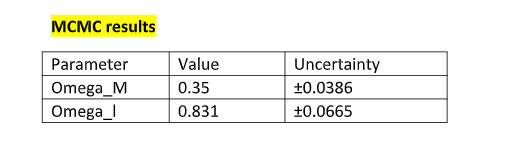